In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import batman
import random
import astropy
from astropy.io import ascii
from scipy import constants

In [2]:
#Define constants
M_sun = 1.989e+30
R_sun = 695700000
R_Earth = 6378100
day = 86400
AU = 1.496e+11

In [4]:
def planetmaker(rates, radius_low, radius_up, period_low, period_up):
    '''Generates parameters for a planet from occurence rates'''
    rowdex = np.arange(len(rates))
    anglew = np.random.uniform(low=-1.*np.pi, high=np.pi)
    e = np.random.beta(a=1.03, b=13.6)
    rows = np.random.choice(rowdex, p=rates)
    radp = np.random.uniform(low=radius_low[rows], high=radius_up[rows])
    per = np.random.uniform(low=period_low[rows], high=period_up[rows])
    return radp, per, anglew, e

In [5]:
table = ascii.read('norm_rates_FGK.csv', format='csv', header_start=0, data_start=1)
occ = np.array(table['f'], dtype=float)
radbinlower = np.array(table['rmin'], dtype=float)
radbinupper = np.array(table['rmax'], dtype=float)
pbinlower = np.array(table['pmin'], dtype=float)
pbinupper = np.array(table['pmax'], dtype=float)

In [6]:
#Generate a random temperature. In the final pipeline Temperature will be chosen from TICv8
T_eff = np.random.uniform(3700.0, 7500.0)

In [7]:
#Assign spectral type based on temperature
if 7500<= T_eff <10000:
    spectral_type = 'A'
if 6000<= T_eff <7500:
    spectral_type = 'F'
if 5200<= T_eff <6000:
    spectral_type = 'G'
if 3700<= T_eff < 5200:
    spectral_type = 'K'
if 2400<= T_eff < 3700:
    spectral_type = 'M'

In [8]:
#Choose mass and radius dependent on spectral type. In the final pipeline these will come from TICv8
if spectral_type == 'A':
    M_star = np.random.uniform(2.1, 1.4)
    R_star = np.random.uniform(1.4, 1.8)
if spectral_type == 'F':
    M_star = np.random.uniform(1.04, 1.4)
    R_star = np.random.uniform(1.15, 1.4)
if spectral_type == 'G':
    M_star = np.random.uniform(0.8, 1.04)
    R_star = np.random.uniform(0.96, 1.15)
if spectral_type == 'K':
    M_star = np.random.uniform(0.45, 0.8)
    R_star = np.random.uniform(0.7, 0.96)
if spectral_type == 'M':
    M_star = np.random.uniform(0.08, 0.45)
    R_star = np.random.uniform(0.1, 0.8)

In [9]:
radius, period, peri, ecc = planetmaker(occ, radbinlower, radbinupper, pbinlower, pbinupper)

In [10]:
#Generate b and cosi such that planet always transits
a = np.cbrt((constants.G*(M_star*M_sun)*np.square(period*day))/(4*np.square(np.pi)))
k = (radius*R_Earth)/(R_star*R_sun)
b = np.random.uniform(low=0., high=1.+k)
cosi = (R_star*R_sun*b*(1.+ecc*np.sin(peri)))/(a*(1.-np.square(ecc)))
inc = np.degrees(np.arccos(cosi))

In [11]:
#Generate range of Time values to test for in/out transit times in TESS BJD, assuming a mission duration of 10 years and a cadence of 20s
T_start = 0.0
T_end = 3650.0
cadence = 20.0
T_range = np.arange(T_start, T_end, step=cadence/day, dtype=float)
#Calculate Transit duration
T_dur = (period*day/np.pi)*np.arcsin((R_star*R_sun/a)*np.sqrt(1+k-np.square(b))/np.sqrt(1-np.square(cosi)))
T_0 = np.random.uniform(low=T_start, high=T_start+period) #First possible to observe transit ingress time
#Generate orbital phase with 0 at T_1
phi = ((T_range - T_0)%period)/period
#Use phase to generate simple boolean transit model
In_transit = (phi >= 0) & (phi <= ((T_dur/day)/period))

In [13]:
print(spectral_type, 'type star')
print('Planet')
print('Radius = ',radius, 'Earth Radii')
print('Period =', period, 'days')
print('Inclination angle =', inc, 'deg')
print('Eccentricity =', ecc)
print('Semi major axis =',a/AU, 'AU')
print('Impact parameter, b =', b)
print('Transit duration =', T_dur/3600, 'hours')

K type star
Planet
Radius =  3.6255730985025 Earth Radii
Period = 115.3544419329047 days
Inclination angle = 89.789368363827 deg
Eccentricity = 0.019180229662509984
Semi major axis = 0.42291996088266653 AU
Impact parameter, b = 0.349512587604726
Transit duration = 8.689306490007565 hours


<IPython.core.display.Javascript object>


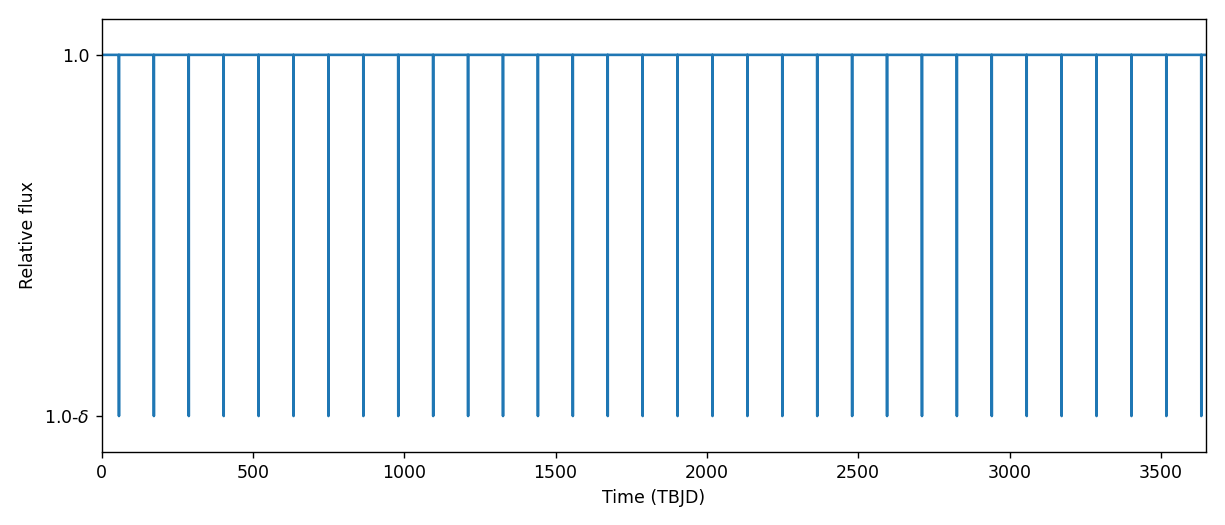

In [14]:
#Plot the simple Boolean In/out transit model
plt.figure(num=1, figsize=[9.8, 4.2])
plt.plot(T_range, np.invert(In_transit))
plt.xlabel('Time (TBJD)')
plt.ylabel('Relative flux')
plt.yticks([1.0, 0.0], ['1.0', '1.0-$\delta$'])
plt.xlim(T_start, T_end)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.show()

In [15]:
#Slightly more complex model with actual transit depth included
f = np.ones_like(T_range)
f[In_transit] = 1-np.square(k)

<IPython.core.display.Javascript object>


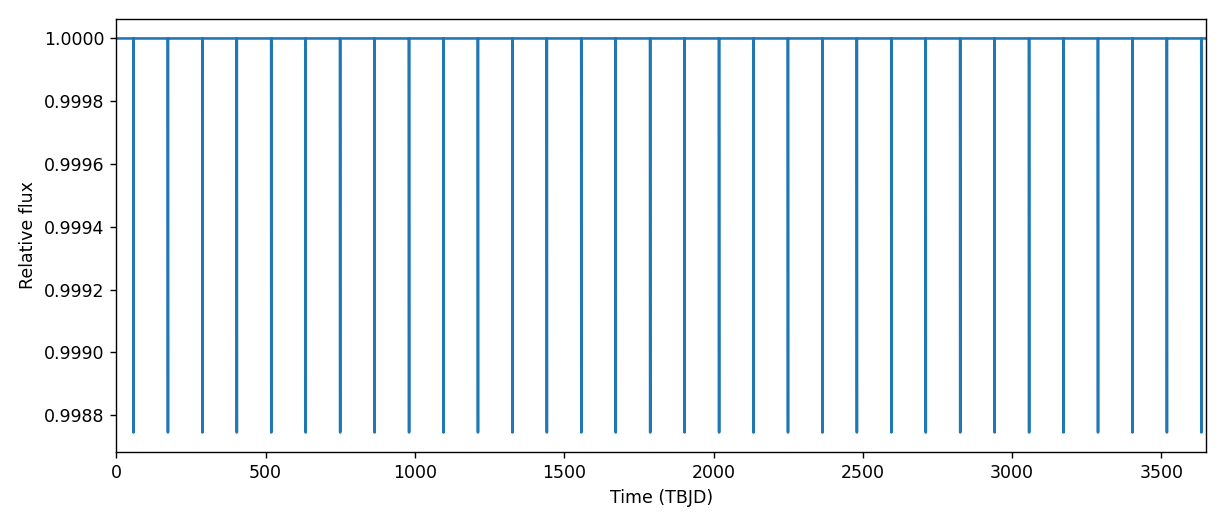

In [16]:
#Plot square transit model with depth
plt.figure(num=2, figsize=[9.8, 4.2])
plt.plot(T_range, f)
plt.xlabel('Time (TBJD)')
plt.ylabel('Relative flux')
plt.xlim(T_start, T_end)
plt.tight_layout()
plt.show()